In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to fit the network input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=transform)


/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


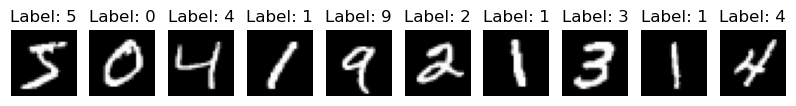

In [2]:
import matplotlib.pyplot as plt

def visualize_samples(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i, ax in enumerate(axes):
        ax.imshow(dataset.data[i].numpy(), cmap='gray')
        ax.set_title(f'Label: {dataset.targets[i]}')
        ax.axis('off')
    plt.show()

visualize_samples(mnist_trainset)


In [3]:
# Splitting the dataset
train_size = int(0.9 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
mnist_train, mnist_val = random_split(mnist_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32, shuffle=False)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimVGG16(nn.Module):
    def __init__(self):
        super(SimVGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # Adjust for 1 channel input
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimVGG16()


Epoch 1 training loss: 0.23784857811750051
Epoch 1 validation loss: 0.05018260655630544
Epoch 2 training loss: 0.07588072865223802
Epoch 2 validation loss: 0.037355624421639304
Epoch 3 training loss: 0.055324859709729016
Epoch 3 validation loss: 0.03428262493876088
Epoch 4 training loss: 0.04680018569650555
Epoch 4 validation loss: 0.030748224833896918
Epoch 5 training loss: 0.040878797885421654
Epoch 5 validation loss: 0.029987350004840336
Epoch 6 training loss: 0.034845016810503206
Epoch 6 validation loss: 0.040479727184219126
Epoch 7 training loss: 0.0342493992258842
Epoch 7 validation loss: 0.03563037999086365
Epoch 8 training loss: 0.029262045187269322
Epoch 8 validation loss: 0.035745934390634594
Epoch 9 training loss: 0.026924829671323768
Epoch 9 validation loss: 0.031983991495395755
Epoch 10 training loss: 0.024764009623759416
Epoch 10 validation loss: 0.03294661786415652
Epoch 11 training loss: 0.022112799314844046
Epoch 11 validation loss: 0.030541125600270058
Epoch 12 traini

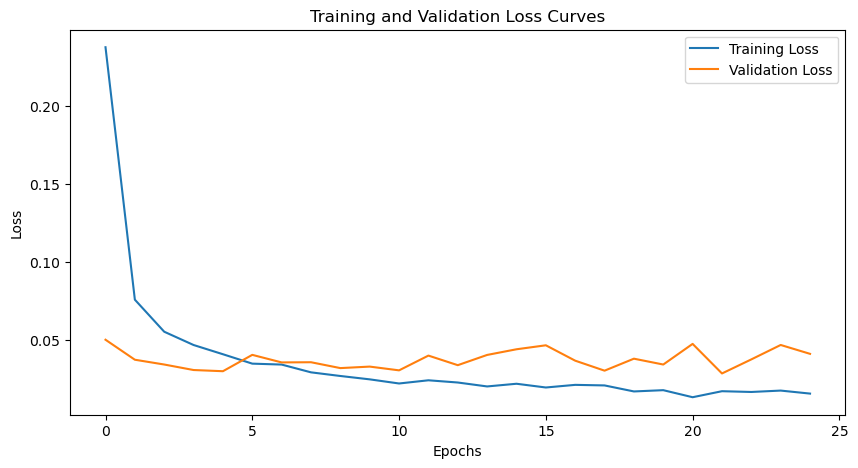

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Initialize lists to track the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(25):  # Adjust the number of epochs as needed
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record training loss
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Record validation loss
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Evaluate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

# Predict on the test set
test_loader = DataLoader(mnist_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  # Print the first 10 predictions


Accuracy of the network on the validation images: 99.08333333333333%
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
